In [134]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from matcher import Dinov2Matcher
from utils.spd import read_pointcloud
from utils.geometric_vision import solve_pnp_ransac
from torchvision import transforms
import matplotlib.pyplot as plt
from utils.spd import depth_map_to_pointcloud
from utils.spd import  transform_pointcloud
import random

In [230]:
from ref_dataset import ReferenceDataset, SimTestDataset

shuffle = True
random.seed(11)
np.random.seed(11)
torch.manual_seed(11)

vis_dataset = SimTestDataset(features=True)
ref_dataset = ReferenceDataset(dataset_location="/root/autodl-tmp/shiqian/code/gripper/render_lowres", num_views=840,features=True)
ref_dataloader = DataLoader(ref_dataset, batch_size=1, shuffle=shuffle)
refs = next(iter(ref_dataloader))
vis_dataloader = DataLoader(vis_dataset, batch_size=1, shuffle=shuffle)
iterloader = iter(vis_dataloader)

Loading reference view dataset...
Found 64 views in /root/autodl-tmp/shiqian/code/gripper/render_random
Loading reference view dataset...
Found 840 views in /root/autodl-tmp/shiqian/code/gripper/render_lowres


Initializing DinoV2 Matcher...
Preprocessing reference views...
Reference view features obtained
DinoV2 Matcher done initialized
depth_maps torch.Size([840, 180, 320])
depths torch.Size([3358])
c2os: torch.Size([3358, 4, 4])
torch.Size([3358, 3])
torch.Size([144, 6])
gt_cam_to_obj: [[ 0.50621801  0.81418781  0.28432643 -0.28432636]
 [-0.63960122  0.57559718 -0.50950777  0.50950787]
 [-0.57849248  0.07606648  0.8121332  -0.81213321]
 [ 0.          0.          0.          1.        ]]


(-0.5, 319.5, 179.5, -0.5)

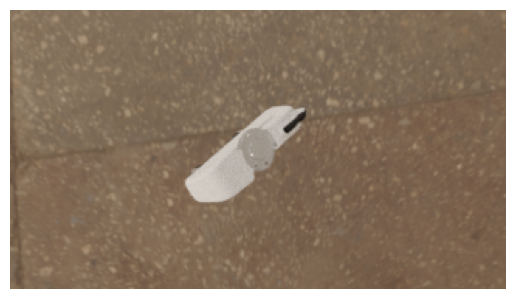

In [231]:
# code from match.run_model

d = next(iterloader)
gripper_pointcloud = read_pointcloud("./pointclouds/gripper.txt")
device = 'cuda:0'
matcher = Dinov2Matcher(refs=refs, model_pointcloud=gripper_pointcloud, device=device)

rgbs = torch.Tensor(d['rgb']).float().permute(0, 3, 1, 2).to(device) # B, C, H, W
depths = torch.Tensor(d['depth']).float().permute(0, 3, 1, 2).to(device)
masks = torch.Tensor(d['mask']).float().permute(0, 3, 1, 2).to(device)
c2ws = d['c2w'] # B, 4, 4
o2ws = d['obj_pose'] # B, 4, 4
intrinsics = d['intrinsics']
matches_3d = matcher.match_and_fuse(d)     # N, 6

test_camera_K = np.zeros((3,3))
test_camera_K[0,0] = intrinsics['fx']
test_camera_K[1,1] = intrinsics['fy']
test_camera_K[0,2] = intrinsics['cx']
test_camera_K[1,2] = intrinsics['cy']
test_camera_K[2,2] = 1
gt_pose = np.dot(np.linalg.inv(o2ws[0]), c2ws[0])
print("gt_cam_to_obj:", gt_pose)
gt_key_pointcloud = transform_pointcloud(np.array(matches_3d[:,3:].cpu()),np.linalg.inv(gt_pose))

matches_3d[:,[1,2]] = matches_3d[:,[2,1]] 
pnp_retval, translation, rt_matrix = solve_pnp_ransac(matches_3d[:,3:6].cpu().numpy(), matches_3d[:,1:3].cpu().numpy(), camera_K=test_camera_K)

test_pointcloud_cam = depth_map_to_pointcloud(depths[0,0], masks[0,0], intrinsics)
test_pointcloud_cam2obj = transform_pointcloud(test_pointcloud_cam, np.linalg.inv(rt_matrix))
test_pointcloud_obj2cam = transform_pointcloud(gripper_pointcloud, rt_matrix)
key_pointcloud = transform_pointcloud(np.array(matches_3d[:,3:].cpu()), rt_matrix)

fig = plt.figure()
plt.subplot(1,1, 1)
plt.imshow(np.array((rgbs[0].permute(1,2,0)/255.0).cpu()))
plt.axis('off')

In [250]:
print(test_pointcloud_cam.shape)     # 由深度图算出的实际位置
print(gt_key_pointcloud.shape)       # 由pose计算出的关键点的实际位置
print(test_pointcloud_obj2cam.shape) # 预测位置
print(key_pointcloud.shape)  # 关键3d点 预测的3d位置
print(gripper_pointcloud.shape)

(2165, 3)
(144, 3)
(8192, 3)
(144, 3)
(8192, 3)


In [288]:
import plotly.graph_objects as go
# point_tmp = np.array(torch.tensor([[ 1.2779e-02,  3.8695e-02,  1.1593e+00],
#         [ 1.5801e-02,  4.0515e-02,  1.1590e+00],
#         [ 1.7830e-02,  4.1860e-02,  1.1585e+00],
#         [ 1.5865e-03,  2.9161e-02,  1.1695e+00],
#         [ 2.9300e-03,  3.0547e-02,  1.1678e+00],
#         [ 8.6776e-03,  3.6207e-02,  1.1597e+00],
#         [-4.8517e-03,  2.0261e-02,  1.1860e+00],
#         [ 1.2897e-02,  3.8780e-02,  1.1596e+00],
#         [ 3.6002e-02,  4.3903e-02,  1.1663e+00],
#         [-3.7300e-03,  1.7645e-02,  1.1955e+00],
#         [ 1.6903e-02,  4.1141e-02,  1.1590e+00],
#         [ 1.6103e-02,  4.0625e-02,  1.1589e+00],
#         [ 1.5278e-02,  4.0248e-02,  1.1590e+00],
#         [ 1.6293e-02,  4.0853e-02,  1.1591e+00],
#         [ 2.1078e-02,  4.2082e-02,  1.1608e+00],
#         [ 6.4630e-02,  5.4551e-02,  1.1721e+00],
#         [ 1.1225e-02, -2.4072e-02,  1.3487e+00],
#         [-2.7564e-05,  2.7404e-02,  1.1720e+00],
#         [ 1.4687e-03,  2.9036e-02,  1.1696e+00],
#         [-4.1488e-03,  1.9150e-02,  1.1895e+00],
#         [ 6.9619e-03,  3.4944e-02,  1.1605e+00],
#         [ 1.7487e-02,  4.1604e-02,  1.1586e+00],
#         [ 1.6293e-02,  4.0853e-02,  1.1591e+00],
#         [ 1.6293e-02,  4.0853e-02,  1.1591e+00],
#         [ 1.8240e-02,  4.1889e-02,  1.1587e+00],
#         [ 4.3879e-04,  2.7871e-02,  1.1713e+00],
#         [ 1.2028e-03,  2.8441e-02,  1.1708e+00],
#         [ 1.0772e-02,  3.7110e-02,  1.1607e+00],
#         [-2.8925e-03,  1.9102e-02,  1.1912e+00],
#         [ 1.7830e-02,  4.1860e-02,  1.1585e+00],
#         [ 1.6064e-02,  4.0696e-02,  1.1592e+00],
#         [ 2.3137e-02, -2.3207e-02,  1.3520e+00],
#         [ 6.8354e-02,  5.9262e-02,  1.1750e+00],
#         [ 1.0066e-02,  3.6644e-02,  1.1597e+00],
#         [-3.9467e-03,  1.7893e-02,  1.1929e+00],
#         [ 2.2139e-02,  4.4176e-02,  1.1647e+00],
#         [ 1.4571e-03,  2.1680e-02,  1.1920e+00],
#         [ 5.7473e-02,  6.6297e-02,  1.1770e+00],
#         [ 4.2603e-02,  5.3361e-02,  1.1702e+00],
#         [ 3.7537e-02, -3.7001e-02,  1.3481e+00],
#         [ 3.6151e-02, -2.3384e-02,  1.3548e+00],
#         [ 6.9264e-02,  6.4091e-02,  1.1781e+00],
#         [ 6.3619e-02,  6.8186e-02,  1.1790e+00],
#         [ 3.9432e-02, -3.2034e-02,  1.3500e+00],
#         [ 3.7569e-02, -2.3240e-02,  1.3550e+00],
#         [ 6.8066e-02,  6.7134e-02,  1.1815e+00],
#         [ 4.9630e-03,  4.0370e-02,  1.1855e+00],
#         [ 4.8812e-03, -6.0309e-02,  1.3133e+00],
#         [ 7.1975e-03,  4.2843e-02,  1.1865e+00],
#         [ 7.4747e-03, -5.9802e-02,  1.3126e+00],
#         [ 4.0345e-02, -2.4389e-02,  1.3541e+00],
#         [ 7.1973e-02,  6.0063e-02,  1.1782e+00],
#         [ 6.2060e-02,  7.6429e-02,  1.1896e+00],
#         [ 4.7693e-03,  3.3112e-02,  1.2073e+00],
#         [-1.1719e-02, -1.5573e-03,  1.2821e+00],
#         [ 4.8499e-02,  5.9696e-02,  1.1737e+00],
#         [ 2.8151e-02, -4.0637e-02,  1.3435e+00],
#         [ 6.6324e-03, -3.2988e-02,  1.3421e+00],
#         [ 4.3114e-02,  6.2751e-02,  1.1749e+00],
#         [ 2.1548e-02, -4.7555e-02,  1.3376e+00],
#         [ 3.8383e-02, -3.6274e-02,  1.3486e+00],
#         [ 7.6818e-03, -5.5371e-02,  1.3264e+00],
#         [ 4.5408e-02,  4.4970e-02,  1.1664e+00],
#         [ 4.2330e-02, -2.8174e-02,  1.3522e+00],
#         [ 7.0246e-02,  6.1704e-02,  1.1781e+00],
#         [ 6.2846e-02,  7.5713e-02,  1.1877e+00],
#         [ 1.5028e-02, -2.4494e-02,  1.3495e+00],
#         [ 7.2201e-02,  2.2228e-03,  1.3272e+00],
#         [ 8.3908e-02,  5.7825e-02,  1.2206e+00],
#         [ 7.1755e-02,  7.3264e-04,  1.3274e+00],
#         [ 8.4376e-02,  5.9940e-02,  1.2213e+00],
#         [ 7.3256e-02,  3.2418e-03,  1.3274e+00],
#         [ 9.0702e-02,  5.3541e-02,  1.2259e+00],
#         [ 7.1844e-02,  2.5341e-03,  1.3281e+00],
#         [ 8.8144e-02,  5.9278e-02,  1.2268e+00],
#         [ 7.1225e-02,  1.4552e-03,  1.3281e+00],
#         [ 8.4051e-02,  6.1427e-02,  1.2225e+00],
#         [ 7.4128e-02,  3.4029e-03,  1.3278e+00],
#         [ 8.7541e-02,  5.9950e-02,  1.2240e+00],
#         [ 7.6589e-02,  5.1733e-03,  1.3276e+00],
#         [ 9.3874e-02,  5.5660e-02,  1.2296e+00],
#         [-5.6722e-03, -1.1425e-02,  1.2760e+00],
#         [ 7.2897e-02,  3.5696e-03,  1.3282e+00],
#         [ 8.9160e-02,  5.8883e-02,  1.2277e+00],
#         [ 7.3336e-02,  3.9349e-03,  1.3282e+00],
#         [ 8.7267e-02,  6.0448e-02,  1.2247e+00],
#         [ 7.4259e-02,  5.0318e-03,  1.3284e+00],
#         [ 8.9179e-02,  5.9654e-02,  1.2278e+00],
#         [ 8.1612e-02,  1.1373e-02,  1.3290e+00],
#         [ 9.3811e-02,  5.7060e-02,  1.2306e+00],
#         [ 8.3987e-02,  1.1042e-02,  1.3286e+00],
#         [ 9.8331e-02,  5.7774e-02,  1.2302e+00],
#         [-5.1944e-03, -1.2568e-02,  1.2763e+00],
#         [ 7.2960e-02,  2.7424e-03,  1.3276e+00],
#         [ 8.7341e-02,  5.9041e-02,  1.2277e+00],
#         [ 7.4692e-02,  4.5964e-03,  1.3279e+00],
#         [ 8.8715e-02,  5.9225e-02,  1.2284e+00],
#         [ 8.1612e-02,  1.1373e-02,  1.3290e+00],
#         [ 9.2545e-02,  5.6788e-02,  1.2308e+00],
#         [ 8.3617e-02,  1.1840e-02,  1.3295e+00],
#         [ 9.8583e-02,  5.8472e-02,  1.2312e+00],
#         [ 7.6807e-02,  4.6493e-03,  1.3271e+00],
#         [ 9.2723e-02,  5.4706e-02,  1.2268e+00],
#         [ 8.3598e-02,  1.0803e-02,  1.3290e+00],
#         [ 9.8168e-02,  5.6986e-02,  1.2290e+00],
#         [ 8.9163e-02,  9.1386e-03,  1.3244e+00],
#         [ 9.2472e-02,  6.4116e-02,  1.2404e+00],
#         [ 8.5411e-02,  2.2774e-02,  1.3296e+00],
#         [ 6.9676e-02,  1.7517e-02,  1.2451e+00],
#         [ 6.7852e-02,  8.2794e-03,  1.3223e+00],
#         [ 8.4089e-02,  5.3058e-02,  1.2262e+00],
#         [ 8.7874e-02,  5.3314e-02,  1.2290e+00],
#         [ 6.8622e-02,  9.7459e-03,  1.3242e+00],
#         [ 8.0254e-02,  1.5418e-02,  1.3202e+00],
#         [ 9.6361e-02,  5.4404e-02,  1.2379e+00],
#         [ 8.2808e-02,  1.7660e-02,  1.3197e+00],
#         [ 9.8987e-02,  5.3570e-02,  1.2395e+00],
#         [ 9.9840e-02,  5.4324e-02,  1.2409e+00],
#         [ 8.7389e-02,  2.0075e-02,  1.3191e+00],
#         [ 6.7638e-02,  9.3116e-03,  1.3230e+00],
#         [ 6.9676e-02,  1.7517e-02,  1.2451e+00],
#         [ 8.5876e-02,  5.6365e-02,  1.2303e+00],
#         [ 8.9053e-02,  5.5408e-02,  1.2315e+00],
#         [ 6.8690e-02,  9.2982e-03,  1.3227e+00],
#         [ 6.9676e-02,  1.7517e-02,  1.2451e+00],
#         [ 8.8736e-02,  5.4040e-02,  1.2292e+00],
#         [ 7.0979e-02,  1.0104e-02,  1.3242e+00],
#         [ 7.6585e-02,  1.1711e-02,  1.3223e+00],
#         [ 9.3777e-02,  5.5142e-02,  1.2353e+00],
#         [ 8.1502e-02,  1.6543e-02,  1.3198e+00],
#         [ 9.7768e-02,  5.3969e-02,  1.2389e+00],
#         [ 8.5216e-02,  2.0448e-02,  1.3176e+00],
#         [ 9.8820e-02,  5.5142e-02,  1.2450e+00],
#         [ 8.6488e-02,  2.0381e-02,  1.3175e+00],
#         [ 9.9531e-02,  5.5728e-02,  1.2461e+00],
#         [ 9.0798e-02,  2.0830e-02,  1.3198e+00],
#         [ 1.0113e-01,  5.6847e-02,  1.2452e+00],
#         [ 2.9276e-02, -4.3057e-03,  1.3390e+00],
#         [ 7.0219e-02,  3.9573e-02,  1.1916e+00],
#         [ 8.7891e-02,  5.2030e-02,  1.2265e+00],
#         [ 6.7370e-02,  1.0576e-02,  1.3246e+00],
#         [ 8.8266e-02,  5.3175e-02,  1.2278e+00],
#         [ 6.6299e-02,  1.0526e-02,  1.3249e+00],
#         [ 9.3669e-02,  5.5572e-02,  1.2357e+00],
#         [ 7.8227e-02,  1.4081e-02,  1.3217e+00],
#         [ 9.7487e-02,  5.4362e-02,  1.2385e+00],
#         [ 8.0560e-02,  1.6728e-02,  1.3206e+00],
#         [ 8.3811e-02,  1.9843e-02,  1.3181e+00],
#         [ 9.8021e-02,  5.4762e-02,  1.2439e+00],
#         [ 9.9802e-02,  5.5629e-02,  1.2462e+00],
#         [ 8.6626e-02,  2.0747e-02,  1.3177e+00],
#         [ 8.8460e-02,  1.6845e-02,  1.3218e+00],
#         [ 9.5680e-02,  6.6058e-02,  1.2431e+00],
#         [ 1.0527e-01,  5.4274e-02,  1.2422e+00],
#         [ 9.0920e-02,  1.9038e-02,  1.3208e+00],
#         [ 1.0287e-01,  5.8438e-02,  1.2458e+00]], device='cuda:0').cpu())
point_cloud = np.concatenate((test_pointcloud_cam,
                              test_pointcloud_obj2cam,
                              key_pointcloud,
                              gt_key_pointcloud,
                             # point_tmp
                             ),
                             axis=0)

n1 = test_pointcloud_cam.shape[0]
n2 = test_pointcloud_obj2cam.shape[0]
n3 = key_pointcloud.shape[0]
n4 = gt_key_pointcloud.shape[0]

point_color = np.zeros((20000,3),dtype=float)
point_color[:n1] = np.array([1,0,0])        # 红色的点是实际位置
point_color[n1:n1+n2] = np.array([0,1,0]) # 绿色的点是预测位置
point_color[n1+n2:n1+n2+n3] = np.array([0,0,1]) 
point_color[n1+n2+n3:n1+n2+n3+n4] = np.array([0,1,1])

fig = go.Figure(data=[go.Scatter3d(
    x=point_cloud[:, 0],
    y=point_cloud[:, 1],
    z=point_cloud[:, 2],
    mode='markers',
    marker=dict(
        size=5,  # 调整节点的大小
        color=point_color,  # 给点云上色
        opacity=0.95
    )
)])
fig.update_layout(width=1000, height=1000)
fig.update_scenes(aspectmode='data')
fig.show()

torch.Size([144, 6])


(-0.5, 319.5, 179.5, -0.5)

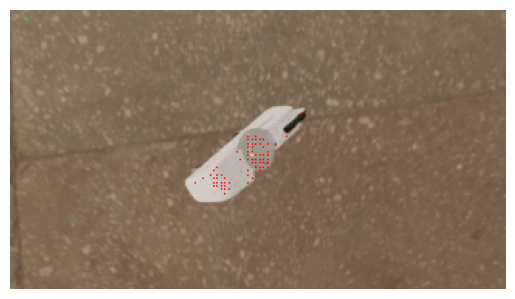

In [234]:
# match_3d中，选的关键点的实际位置
fig = plt.figure()
plt.subplot(1,1,1)
print(matches_3d.shape)
image = np.array((rgbs[0].permute(1,2,0)/255.0).cpu())
for i_match in range(matches_3d.shape[0]):
    y,x = int(matches_3d[i_match,1].cpu().numpy()), int(matches_3d[i_match,2].cpu().numpy())
    image[x,y] = [1,0,0]
image[5,10] = [0,1,0]
plt.imshow(image)
plt.axis('off')

(144, 3)


(-0.5, 319.5, 179.5, -0.5)

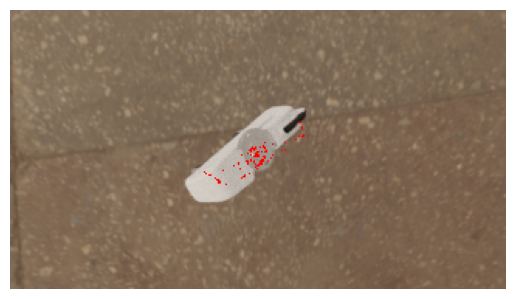

In [235]:
# 把预测出来的3d点云投影回2d上
# 只把matches中的3D关键点，用预测的RT转换，然后投影回2d

print(key_pointcloud.shape)
project_2d = (np.dot(test_camera_K,np.array(key_pointcloud.transpose(1,0)))/np.array(key_pointcloud.transpose(1,0))[2,:]).transpose(1,0)[:,:2]
# print(project_2d)
image = np.array((rgbs[0].permute(1,2,0)/255.0).cpu())
for i in range(project_2d.shape[0]):
    y,x = int(project_2d[i,0]), int(project_2d[i,1])
    image[x,y] = [1,0,0]

plt.subplot(1,1, 1)
plt.imshow(image)
plt.axis('off')

torch.Size([4, 4])
tensor(182.3902, device='cuda:0', grad_fn=<AddBackward0>)


(-0.5, 319.5, 179.5, -0.5)

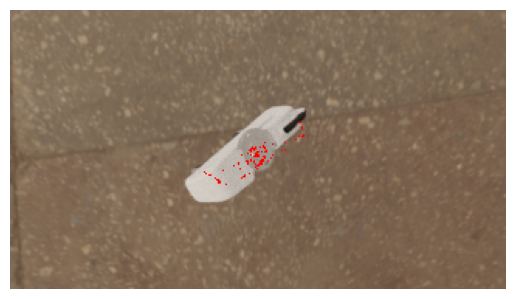

In [264]:
# 测试四元数相关函数的正确性

from utils.quaternion_utils import *

rt_matrix = torch.tensor(rt_matrix,device=matches_3d.device, dtype=matches_3d.dtype)          # 4,4
print(rt_matrix.shape)
test_camera_K = torch.tensor(test_camera_K,device=matches_3d.device, dtype=matches_3d.dtype)  # 3,3
gt_pose = torch.tensor(gt_pose,device=matches_3d.device, dtype=matches_3d.dtype)              # 4,4
q_pred = torch.tensor(matrix_to_quaternion(rt_matrix[:3,:3]),requires_grad=True)    # 4


fact_2d = matches_3d[:, 1:3]    # 342,2
# use rotation matrix to change:
# transform_pointcloud(matches_3ds[i][:, 3:], gt_poses[i]@torch.inverse(gt_poses[0])@rt_pred)
pred_3d = quaternion_apply(q_pred,matches_3d[:, 3:]) + rt_matrix[:3,3]
pred_3d = quaternion_apply(matrix_to_quaternion(torch.inverse(gt_pose)[:3,:3]),pred_3d) + torch.inverse(gt_pose)[:3,3]
pred_3d = quaternion_apply(matrix_to_quaternion(gt_pose[:3,:3]),pred_3d) + gt_pose[:3,3]

proj_2d = ((test_camera_K@pred_3d.transpose(1, 0))/pred_3d.transpose(1, 0)[2,:]).transpose(1, 0)[:, :2]
loss = torch.mean((fact_2d - proj_2d)**2) + (torch.norm(q_pred)-1)**2

print(loss)
# 按理来说，这里应该是一样的图片

# print(project_2d)
image = np.array((rgbs[0].permute(1,2,0)/255.0).cpu())
for i in range(proj_2d.shape[0]):
    y,x = int(proj_2d[i,0]), int(proj_2d[i,1])
    image[x,y] = [1,0,0]

plt.subplot(1,1, 1)
plt.imshow(image)
plt.axis('off')

(-0.5, 319.5, 179.5, -0.5)

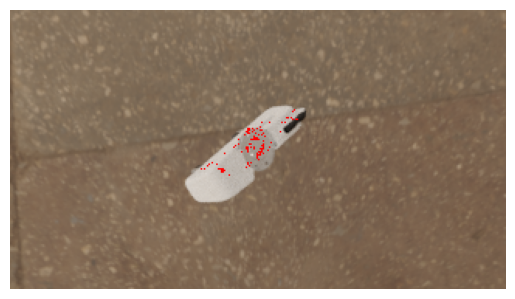

In [286]:
# 在2d图像上，查看优化后的效果
q_demo = torch.tensor([ 0.8503, -0.1714, -0.2562,  0.4268], device='cuda:0',
       requires_grad=True)
t_demo = torch.tensor([-1.5169e-03, -7.1269e-04,  1.0793e+00], device='cuda:0',
       requires_grad=True)

point_demo = quaternion_apply(q_demo,matches_3d[:, 3:]) + t_demo
point_demo_full = quaternion_apply(q_demo,torch.tensor(gripper_pointcloud,device='cuda:0')) + t_demo
proj_demo = ((test_camera_K@point_demo.transpose(1, 0))/point_demo.transpose(1, 0)[2,:]).transpose(1, 0)[:, :2]



image = np.array((rgbs[0].permute(1,2,0)/255.0).cpu())
for i in range(proj_demo.shape[0]):
    y,x = int(proj_demo[i,0]), int(proj_demo[i,1])-5
    image[x,y] = [1,0,0]

plt.subplot(1,1, 1)
plt.imshow(image)
plt.axis('off')

In [287]:
# 在3d上查看优化后的效果

point_cloud = np.concatenate((test_pointcloud_cam,
                              test_pointcloud_obj2cam,
                              np.array(point_demo_full.cpu().detach()),
                              key_pointcloud,
                              gt_key_pointcloud,
                              np.array(point_demo.cpu().detach())),
                             axis=0)
n1 = test_pointcloud_cam.shape[0]
n2 = test_pointcloud_obj2cam.shape[0]
n3 = point_demo_full.shape[0]
n4 = key_pointcloud.shape[0]
n5 = gt_key_pointcloud.shape[0]
n6 =  np.array(point_demo.cpu().detach().shape[0])

point_color = np.zeros((30000,3),dtype=float)
point_color[:n1] = np.array([1,0,0])                  # 红色的点是实际位置
point_color[n1:n1+n2] = np.array([0,1,0])             # 绿色的点是预测位置
point_color[n1+n2:n1+n2+n3] = np.array([0,0,1])       # 蓝色是优化后位置
point_color[n1+n2+n3:n1+n2+n3+n4] = np.array([0,1,1])
point_color[n1+n2+n3+n4:n1+n2+n3+n4+n5] = np.array([1,0,1])
point_color[n1+n2+n3+n4+n5:n1+n2+n3+n4+n5+n6] = np.array([1,1,0])
fig = go.Figure(data=[go.Scatter3d(
    x=point_cloud[:, 0],
    y=point_cloud[:, 1],
    z=point_cloud[:, 2],
    mode='markers',
    marker=dict(
        size=5,  # 调整节点的大小
        color=point_color,  # 给点云上色
        opacity=0.95
    )
)])
# fig.update_layout(
#     scene=dict(
#         xaxis=dict(range=[-0.2,0.2]),
#         yaxis=dict(range=[-0.2,0.2]),
#         zaxis=dict(range=[0,1.5])
#     )
# )
fig.update_layout(width=1000, height=1000)
fig.update_scenes(aspectmode='data')
fig.show()